# Applied data analysis
## Self-confidence through quotations:



### Mount the Google Drive in order to access to the files which are located on our drive


In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


### Install and import every packages that will be necessary for the analysis

In [3]:
!pip install pickle-mixin
!pip install pyarrow
!pip install pathlib


import pyarrow
import pandas as pd
import numpy as np
import pathlib
from datetime import datetime
import sys
import bz2
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

##Pre process of the data



In [ ]:
# The following function allows to only keep the attributes when a single evalue is given. 
#The function replaces array of size 1 by its first element
#Indeed, some attributes are associated with an array of value, to make sure that the value we will use is the correct one, 
#we simple get rid of multiple valued element by replacing them with a 'Nan' value.

def rem_mult(array):
  if isinstance(array, np.ndarray):
    if array.size == 1 :
      array = array[0]
    else :
      array = np.nan
  return array


#### Extracting the relevant data from the original files and saving them in a new file


In [ ]:
path_to_file = '/content/drive/MyDrive/ADAprojet2021/Quotebank/quotes-2020.json.bz2' 
path_to_out = '/content/drive/MyDrive/ADAprojet2021/quotes-2020-clean.json.bz2'


quotes_size =[]
with bz2.open(path_to_out, 'wb') as d_file:
    with bz2.open(path_to_file, 'rb') as s_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample as a dictionnary
            if (instance['speaker'] != 'None' and len(instance['qids']) == 1):
              #Get rid of the quotes associated with no speaker as well as 
              # quotes associated with multiple qids
                instance_out = {}
                instance_out['speaker'] = instance['speaker']
                instance_out['qids'] = instance['qids']
                #remove [ and ] 
                instance_out['quotation'] = instance['quotation'].replace("[ ", "").replace(" ]", "")      
                size = len(instance_out['quotation'].split())
                quotes_size.append(size)
                #Add the size of the quote in our new file
                instance_out['size'] = size 
                d_file.write((json.dumps(instance_out)+'\n').encode('utf-8')) # writing in the new file
            

## First step: pre-process the quotation

  Indeed, since the whole analysis for this project is based on the quotations so it is important to keep only the quotations with comparable size


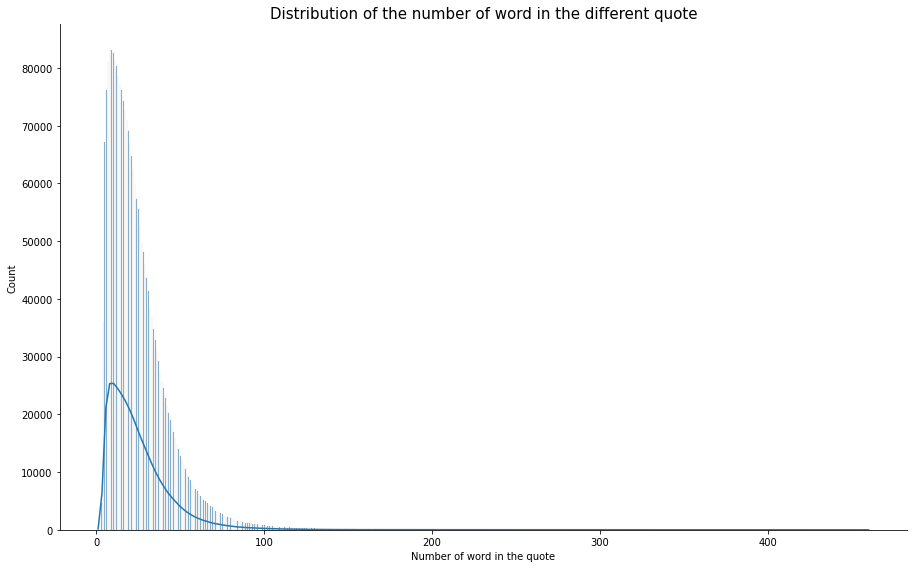

In [ ]:
#See the distribution of the quotation length:
sns.displot(data= quotes_size, kde = True, height=8, aspect=1.6) 
sns.set_style('white')
plt.xlabel('Number of word in the quote')
plt.title("Distribution of the number of word in the different quote", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.show()

According to the distribution, the majority of the quotes are at most 100-words-long. In order to make sure that we analyse complete sentences, we are only going to keep sentences in a range 5 to 100 words long.


In [ ]:
#According to the distribution of the number of word in the quotes, we can select only the quotes containg between 5 and 100 words to make sure that we analyse at least one complete sentence.

path_to_file = '/content/drive/MyDrive/ADAprojet2021/quotes-2020-clean.json.bz2'
path_to_out= '/content/drive/MyDrive/ADAprojet2021/quotes-2020-processed.json.bz2'
quotes_size1 =[]

with bz2.open(path_to_out, 'wb') as d_file:
    with bz2.open(path_to_file, 'rb') as s_file:
        for instance in s_file:
            instance = json.loads(instance) 

            if (5<= instance['size'] <= 100):
              #We only copy the line associated with the qotation size between 5 and 100:
                instance_out = instance

                size = len(instance_out['quotation'].split())
                quotes_size1.append(size)
                d_file.write((json.dumps(instance_out)+'\n').encode('utf-8'))

#Q75 = np.array(quotes_size).quantile(0.75)
#print(Q75)

In [ ]:
sns.displot(data= quotes_size1, kde = True, height=8, aspect=1.6) 
sns.set_style('white')
plt.xlabel('Number of word in the quote')
plt.title("Distribution of the number of word in the different quote", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.show()

## Second step : Pre-process the speakers attributes

During this analysis we are going to use some attributes of the speakers such as their gender, their qids ,their nationality and their US congress bio ID, if there is one.

These extracted attributes will be save in a new file.

The qIDs are kept so they will allow us to navigate between the quote file and the speaker file.

In [ ]:
#This function converts date of birth into datetime format, and replaces 
#by np.nan if speaker was born before 1900
# According to the fact that we are performing a linguistic study, it is essential to make sure that the english spoken is fairily the same. 
#To do so, we decided to select the speakers of interest regarding the date of birth. 
#Such processing makes sure that the speakers are contemporary and may speak similarily.
def dateofbirth(date):
  #Remove speakers who are born before JC
    if date[0] == '-' or date[1:5] == '0000': 
        date = np.nan
    else:
      #Notice here that we are only focusing on the year, this line will set the every birth days and months to first of january
        date = datetime.strptime(date[1:5], '%Y')
        if (date.year < 1900):
            date = np.nan
    return date

#This function removes QIDS found in the sorted data that are irrelevant for the analysis
def gender(id):
    #remove erkek (which is a last name), homosexuality 
    if id == 'Q106299064' or id == 'Q6636':
        return np.nan
    #replace male organism, cis male by male
    if id == 'Q44148' or id == 'Q15145778':
        return 'Q6581097'
    #same for female
    if id== 'Q43445' or id == 'Q15145779':
        return 'Q6581072'
    else :
        return id

#function returns true if us citizen
def us_to_bool(nat):
    if isinstance(nat, np.ndarray):
        return np.isin('Q30', nat)
    else : return False

#function returns true if in congress
def congress(id):
    if isinstance(id, str): return True
    else : return False


In [16]:

#files = pathlib.Path('./parquet').glob('part-*-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet')
files = pathlib.Path("/content/drive/MyDrive/ADAprojet2021/Project datasets/speaker_attributes.parquet/").glob("part-*-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet")
df = pd.DataFrame()
columns = ['id', 'label', 'gender','date_of_birth', 'nationality', 'US_congress_bio_ID']
for path in files:
    df = pd.concat([df, pd.read_parquet(path, columns = columns)], join='outer', ignore_index=True)
    df = df.drop_duplicates(subset='id', keep = False)

df.gender = df.gender.apply(lambda x: rem_mult(x))
df.gender = df.gender.apply(lambda x: gender(x))

df.date_of_birth = df.date_of_birth.apply(lambda x: rem_mult(x))

df = df.dropna(subset = ['id', 'gender','date_of_birth'])
df = df.astype({'gender': 'category'})

df.date_of_birth = df.date_of_birth.apply(lambda x: dateofbirth(x))
df = df.dropna(subset = ['date_of_birth'])

df.nationality = df.nationality.apply(lambda x: us_to_bool(x))
df.US_congress_bio_ID = df.US_congress_bio_ID.apply(lambda x: congress(x))


display(df)
print(df.memory_usage(deep=True))
genders = df.gender.unique()


path_to_out = '/content/drive/MyDrive/ADAprojet2021/speaker_attributes_processed.json.bz2'
df.to_json(path_to_out, orient = 'records', compression = 'bz2') 

,id,label,gender,date_of_birth,nationality,US_congress_bio_ID
2,Q18933,Rhoda Griffis,Q6581072,1965-01-01 00:00:00,True,False
3,Q18953,Peter DeLuise,Q6581097,1966-01-01 00:00:00,True,False
4,Q18971,Arthur P. Jacobs,Q6581097,1922-01-01 00:00:00,True,False
8,Q19190,Rupert Grint,Q6581097,1988-01-01 00:00:00,False,False
9,Q19205,Rob Bourdon,Q6581097,1979-01-01 00:00:00,True,False
...,...,...,...,...,...,...
9055974,Q210228,Kozo Yuki,Q6581097,1979-01-01 00:00:00,False,False
9055975,Q210231,Hayato Sasaki,Q6581097,1982-01-01 00:00:00,False,False
9055976,Q210284,Marinaldo Cícero da Silva,Q6581097,1986-01-01 00:00:00,False,False
9055978,Q210462,Christina Hendricks,Q6581072,1975-01-01 00:00:00,True,False


Index                  25786312
id                    211539869
label                 238764324
gender                  3225420
date_of_birth         180504184
nationality             3223289
US_congress_bio_ID      3223289
dtype: int64


Since we are doing an observationnal study, it is important to have a great notion of the distribution according to the different features. 

In [ ]:
plt.figure(figsize=(50,20))
sns.histplot(df.gender)
plt.title("Histogram showing the distribution of gender ", fontsize=30)
plt.xlabel("Gender", fontsize=25)
plt.ylabel("Numbers of individuals", fontsize=25)
plt.yscale('log')
labels = ['transgender female', 'intersex', 'neutrois', 'genderqueer', 'eunuch', 'genderfluid', 'transgender person', 'shemale',
          'transgender male', 'transmasculine', 'two-spirit', 'muxe', 'non-binary', 'third gender', 'agender', 'neutral sex',
         'female', 'male', 'pangender', 'khatoey', 'bigender', 'demiboy', 'X-gender']
plt.xticks(ticks = np.arange(23), labels = labels, rotation=45, fontsize=20)
plt.show()

In [ ]:

x = []
for i in df.date_of_birth:
  x.append(i.year)

sns.displot(data=x, kde = True, height=8, aspect=1.6) 
sns.set_style('white')
plt.xlabel('Year of birth')
plt.xlim(1900,2021)
plt.title("Distribution of the birth years", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.show()

Preprocessing of the citations: Put them in the right format, extract the tense of the citation to properly assign the right score.


In [47]:
#NLP libraries
import spacy, nltk, gensim, sklearn
from nltk import pos_tag, word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


nlp = spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [127]:
path = '/content/drive/MyDrive/ADAprojet2021/quotes-2020-processed.json.bz2'
quotes = pd.DataFrame(columns=('qids','quotation','verbs' 'tense', 'score'))

#create an array containing the tags associated with the tense 
present = ["VBP", "VBZ","VBG"]
past = ["VBD", "VBN"]

with bz2.open(path, 'rb') as s_file:
  for instance in s_file:
    tense = ['None']
    instance = json.loads(instance) 
    text = nltk.word_tokenize(instance['quotation'])
    tags = nltk.pos_tag(text)

    for word,pos in tags:
      tense = [pos for word,pos in tags if np.isin(pos, past + present)]
  #Check if every verbs are conjugated at the same tense, and assigning the tense to the quotes
    if set(tense).issubset(set(present)) == True:
      tense = 'present'
    if set(tense).issubset(set(past)) == True:
      tense = 'past'

    quotes = quotes.append({'qids':instance['qids'], 'quotation':instance['quotation'], 'tense': tense}, ignore_index=True)

KeyboardInterrupt: ignored

In [103]:
#Extract a small part of the whole file to test 
path = '/content/drive/MyDrive/ADAprojet2021/quotes-2020-processed.json.bz2'
test = pd.DataFrame(columns=('qids','quotation'))
i = 0
with bz2.open(path, 'rb') as s_file:
  for instance in s_file:
    instance = json.loads(instance) 
    print(instance)
    print(instance['quotation'])
    i = i + 1
    test = test.append({'qids': instance['qids'], 'quotation': instance['quotation']}, ignore_index=True)
    print(i)
    if i == 10:
      break


{'speaker': 'Sue Myrick', 'qids': ['Q367796'], 'quotation': 'Department of Homeland Security was livid and strongly urged to have the agenda pulled.', 'size': 14}
Department of Homeland Security was livid and strongly urged to have the agenda pulled.
1
{'speaker': 'Meghan King Edmonds', 'qids': ['Q20684375'], 'quotation': 'I met them when they just turned 4 and 7. They were little. They felt like my full-blown stepkids.', 'size': 19}
I met them when they just turned 4 and 7. They were little. They felt like my full-blown stepkids.
2
{'speaker': 'Dexter Smith', 'qids': ['Q5268447'], 'quotation': 'The delay will have an impact on Slough but that might be mitigated by the fact we are going to have this Western Rail Link to Heathrow. It looks like that may come in sooner than Crossrail.', 'size': 37}
The delay will have an impact on Slough but that might be mitigated by the fact we are going to have this Western Rail Link to Heathrow. It looks like that may come in sooner than Crossrail.
3

In [126]:
from nltk.text import Text
import re 

for text in test['quotation']:
  x = text
  print(type(x))
  y = re.match('is', x)
  print(y)

<class 'str'>
None
<class 'str'>
None
<class 'str'>
None
<class 'str'>
None
<class 'str'>
None
<class 'str'>
None
<class 'str'>
None
<class 'str'>
None
<class 'str'>
None
<class 'str'>
None


In [1]:
#si besoin
#pip install -U sentence-transformers

In [4]:
#test de comparaison semantique avec des trucs randoms

sentences = [
    "Three years later, the coffin was still full of Jello.",
    "The fish dreamed of escaping the fishbowl and into the toilet where he saw his friend go.",
    "The person box was packed with jelly many dozens of months later.",
    "He found a leprechaun in his walnut shell."
]

from sentence_transformers import SentenceTransformer

model = SentenceTransformer(r'C:\Users\flore\Desktop\EPFL\MA1\ada\PROJET\pretrained_model') #'bert-base-nli-mean-tokens'

sentence_embeddings = model.encode(sentences)

from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(
    [sentence_embeddings[0]],
    sentence_embeddings[1:]
)

array([[0.22059387, 0.47637683, 0.22743046]], dtype=float32)

In [8]:
#test de comparaison semantique de quelques une de nos citations avec une des phrases types du paper
#j'ai fait comme dans un exemple de BERT que j'ai trouvé sur internet. j'ai pris le pretrained model all-MiniLM-L6-v2


#note: normalement pas besoin d'avoir le model sur l'ordi, il suffit de mettre le nom 'all-MiniLM-L6-v2' et SentenceTransformer va le chercher tout seul sur internet, mais là il y a un bug genre ajd, 
#donc j'ai téléchargé le model sur mon ordi et mis le path
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(r'C:\Users\flore\Desktop\EPFL\MA1\ada\PROJET\pretrained_model') #with model all-MiniLM-L6-v2' # or use 'bert-base-nli-mean-tokens'


#Extract a small part of the whole file to test 
path = r'C:\Users\flore\Desktop\EPFL\MA1\ada\PROJET\quotes-2020-precessed.json.bz2' #path de mon ordi
test = pd.DataFrame(columns=('qids','quotation'))
i = 0
with bz2.open(path, 'rb') as s_file:
  for instance in s_file:
    instance = json.loads(instance) 
    print(instance)
    #print(instance['quotation'])
    i = i + 1
    test = test.append({'quoteID': instance['quoteID'], 'quotation': instance['quotation']}, ignore_index=True)
    #print(i)
    if i == 10:
      break

#embedding des 10 citations
sentence_embeddings = model.encode(test['quotation'])

#comparaison avec une des phrase du paper: cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
to_compare = ["I'm sure it's"]
to_compare_embedding = model.encode(to_compare)

cosine_similarity(
    [to_compare_embedding[0]],
    sentence_embeddings[0:]
)

#l'output ets un array des coefficients de similarité (là ils osnt tous ba vu qu'aucune citation n'a un truc prche de I'm sure it's)

{'quoteID': '2020-01-16-000088', 'quotation': '[ Department of Homeland Security ] was livid and strongly urged to have the agenda pulled.', 'speaker': 'Sue Myrick'}
{'quoteID': '2020-01-24-000168', 'quotation': '[ I met them ] when they just turned 4 and 7. They were little. They felt like my full-blown stepkids.', 'speaker': 'Meghan King Edmonds'}
{'quoteID': '2020-01-17-000357', 'quotation': '[ The delay ] will have an impact [ on Slough ] but that might be mitigated by the fact we are going to have this Western Rail Link to Heathrow. It looks like that may come in sooner than Crossrail.', 'speaker': 'Dexter Smith'}
{'quoteID': '2020-04-02-000239', 'quotation': '[ The scheme ] treats addiction as an illness and the results so far have been extremely encouraging.', 'speaker': 'Barry Coppinger'}
{'quoteID': '2020-03-19-000276', 'quotation': '[ These ] actions will allow households who have an FHA-insured mortgage to meet the challenges of COVID-19 without fear of losing their homes, a

array([[ 0.01433591,  0.02702463,  0.04557954,  0.07573312, -0.02040301,
         0.09890234,  0.07345733,  0.0720223 ,  0.02289211,  0.05893324]],
      dtype=float32)

In [22]:
#autre test avec le début de citation pour voir si il donne bien un score plus élevé pour cette citation
to_compare_2 = ["Department of Homeland Security was livid and"]
to_compare_2_embedding = model.encode(to_compare_2)

cosine_similarity(
    [to_compare_2_embedding[0]],
    sentence_embeddings[0:]
)
#le premier est bien plus élevé

array([[0.7573065 , 0.02370122, 0.0167593 , 0.07905838, 0.12434015,
        0.13122094, 0.01477368, 0.07131456, 0.1100079 , 0.1029016 ]],
      dtype=float32)